In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences v 2.9 kebawah
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Bidirectional, LSTM, GRU, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt


In [2]:
# Menampilkan informasi perangkat GPU yang digunakan
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    device_details = tf.config.experimental.get_device_details(device)
    print(device_details)

try:
    print(f'Found {physical_devices[0]} GPU(s)')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    assert tf.config.experimental.get_memory_growth(physical_devices[0])
    print('Memory growth set to True, using Nvidia V100')
except:
    print('Failed to set memory growth to True')
    pass

{'compute_capability': (7, 0), 'device_name': 'Tesla V100-SXM2-16GB'}
Found PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') GPU(s)
Memory growth set to True, using Nvidia V100


## CNN_TFIDF_UNIGRAM-BIGRAM DROPOUT 0.5
Copyright @I Gde Bagus Janardana Abasan

In [3]:
def process_data():
  dataset = pd.read_csv('../../../data/data_preprocessed/hasil_ekspansi/twitter/DatasetHatespeech_UnigramBigram_Top5_ExpandedTwitter.csv')
  # make data['label_fase_1'] to 0 and 1 binary classifier karena tensor hanya bisa input 0 =< label =< 1
  dataset['label final'] = dataset['label final'].apply(lambda x: 1 if x == 'HS' else 0)

  # to_pd
  y_final = dataset['label final']
  x_final = dataset.drop('label final', axis=1)

  # split
  print("proses splitting....")
  X_train, X_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.1, random_state=0)
  print("done splitting")
  
  return X_train, X_test, y_train, y_test

In [4]:
X_train, X_test, y_train, y_test = process_data()

proses splitting....
done splitting


In [5]:
def create_cnn_model(X_train, X_test, y_train, y_test):
  # reshape
  X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
  X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)

  # CNN model
  model = Sequential()
  model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
  model.add(Flatten())
  model.add(Dense(units=32, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(units=1, activation='sigmoid'))
  optimizer = Adam(learning_rate=0.00005)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  model.build(input_shape=(None, X_train.shape[1], 1))
  model.summary()

  with tf.device('/cpu:0'):
    x = tf.convert_to_tensor(X_train, np.float32)
    y = tf.convert_to_tensor(y_train, np.float32)

  model.fit(x, y, validation_data=(X_test, y_test), epochs=10, batch_size=64)
  loss = model.history.history['loss']
  val_loss = model.history.history['val_loss']
  print("=== MODEL EVALUATE TEST DATA ===")
  score = model.evaluate(X_test, y_test, batch_size=64, verbose=0)
  print()
  print('Validation Accuracy:', score[1])
  print('Validation Loss:', score[0])
  print()

  return model, loss, val_loss

In [6]:
def call(X_train, X_test, y_train, y_test):
  model, loss, val_loss = create_cnn_model(X_train, X_test, y_train, y_test)
  # predict
  y_pred = model.predict(X_test)
  print()

  # confusion matrix
  classreport = classification_report(y_test, y_pred.round(), digits=4)
  print(classreport)
  print()
  accscore = accuracy_score(y_test, y_pred.round())
  precscore = precision_score(y_test, y_pred.round())
  recscore = recall_score(y_test, y_pred.round())
  f1score = f1_score(y_test, y_pred.round())

  return [accscore, precscore, recscore, f1score, loss, val_loss]

In [7]:
result = []
for i in range (5):
  result.append([i+1] + call(X_train, X_test, y_train, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10000, 32)         128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5000, 32)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 160000)            0         
                                                                 
 dense (Dense)               (None, 32)                5120032   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                        

In [8]:
def loss_func(df):
  for idx, val in enumerate(df['No']):
    plt.plot(df['Loss'].iloc[idx])
    plt.plot(df['Val Loss'].iloc[idx])
    plt.title(f'loss function CNN UNIGRAM_BIGRAM_TRIGRAM Dropout 0.5')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.savefig(f'hasil/grafik/lossfunctionGraphics_CNN_UNIGRAM_BIGRAM_DROPOUT0.5_FE_TWITTER_TOP5-{idx+1}.png')
    plt.show()
    plt.clf()

Average Accuracy : 0.8745035105315948
Average Precision : 0.8769046976275895
Average Recall : 0.8955081001472754
Average F1 Score : 0.886037633050293


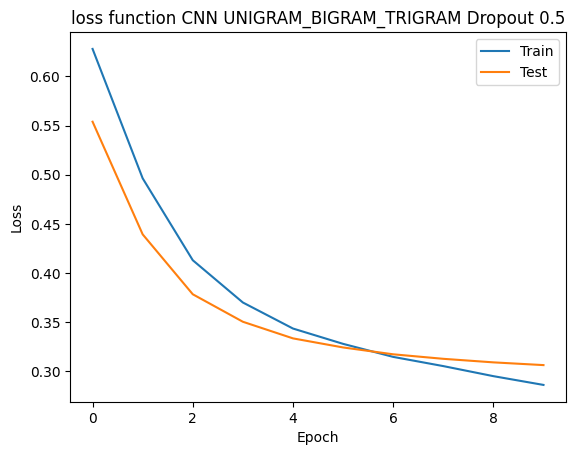

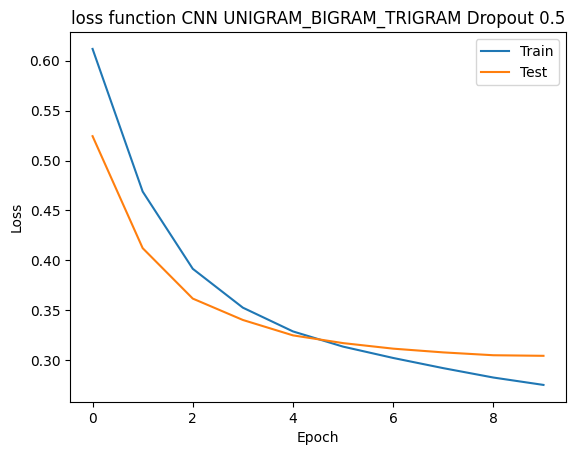

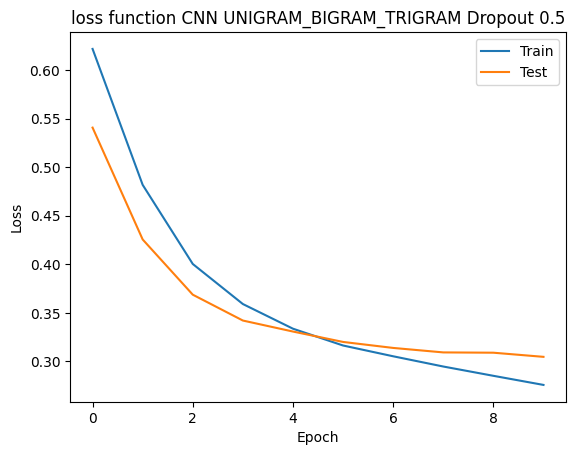

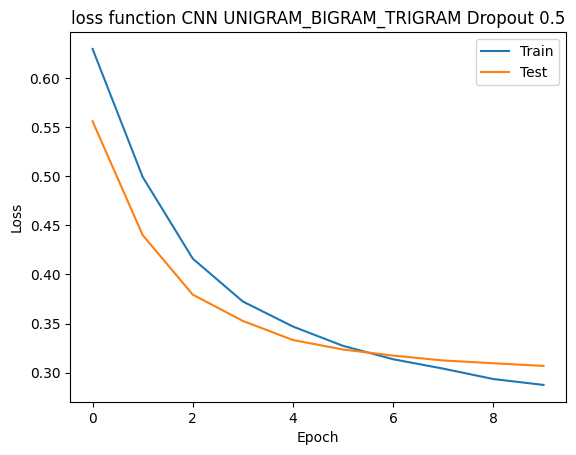

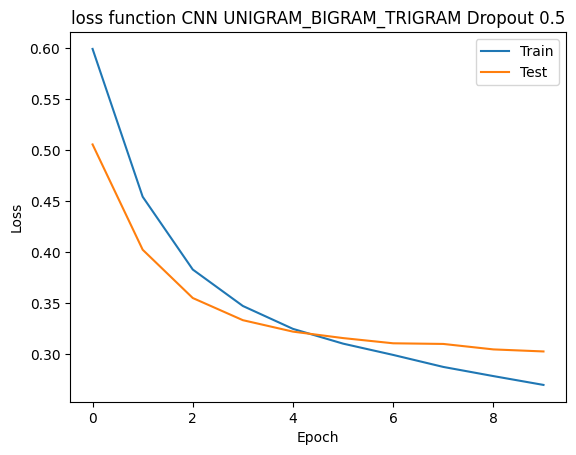

<Figure size 640x480 with 0 Axes>

In [9]:
df = pd.DataFrame(result, columns=['No', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Loss', 'Val Loss'])
df.to_csv('hasil/hasil_CNN_UNIGRAM_BIGRAM_DROPOUT0.5_FE_TWITTER_TOP5.csv', index=False)

#average
print('Average Accuracy :', df['Accuracy'].mean())
print('Average Precision :', df['Precision'].mean())
print('Average Recall :', df['Recall'].mean())
print('Average F1 Score :', df['F1 Score'].mean())
loss_func(df)